In [163]:
!pip install pytrends --upgrade

In [160]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from meteostat import Stations, Daily, Point
from datetime import datetime, date
import matplotlib.pyplot as plt
import holidays

# Loading data and feature engineering

In [2]:
# Load and prepare the data
df = pd.read_csv('Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)

# Add lag and rolling features to the whole dataset
lags = [1, 2, 3, 7, 14, 28]
for lag in lags:
    df[f'lag_{lag}'] = df['attendences'].shift(lag)

rolling_windows = [3]
for window in rolling_windows:
    df[f'rolling_avg_{window}'] = df['attendences'].rolling(window=window).mean()

#adding day of year column
df['day_of_year'] = df.index.dayofyear

#Add precipitation data via meteostat
start = datetime(2009, 1, 1)
end = datetime(2016, 12, 31)
sac = Point(38.5816, -121.4944, 6)

weather = Daily(sac, start, end)
weather = weather.fetch()

df['precipitation'] = weather['prcp']
df['wind_speed'] = weather['wspd']
df['pressure'] = weather['pres']


# adding holiday information
us_holidays = holidays.US(subdiv='CA')
df['holiday'] = df.index.map(lambda x: x in us_holidays)

#add day_before_holiday and day_after_holiday columns
df['day_before_holiday'] = df['holiday'].shift(1)
df['day_after_holiday'] = df['holiday'].shift(-1)

df.dropna(inplace=True)

df['holiday'] = df['holiday'].astype(int)
df['day_before_holiday'] = df['day_before_holiday'].astype(int)
df['day_after_holiday'] = df['day_after_holiday'].astype(int)


# Drop rows with NaN values that were created by shift and rolling
df.drop(['Hosp_ID'], axis=1, inplace=True)

In [113]:
df.tail(5)

,year,monthday,month,day,attendences,min,max,aver,Time_ID,DAT,...,lag_14,lag_28,rolling_avg_3,day_of_year,precipitation,wind_speed,pressure,holiday,day_before_holiday,day_after_holiday
date,,,,,,,,,,,,,,,,,,,,,
2016-12-26,2016,1226,12,26,238.0,-2.0,9.0,3.0,2917,3.5,...,265.0,247.0,192.000000,361,0.0,8.6,1026.1,1,1,0
2016-12-27,2016,1227,12,27,248.0,-1.0,11.0,5.0,2918,5.0,...,243.0,236.0,219.000000,362,0.0,1.8,1027.6,0,1,0
2016-12-28,2016,1228,12,28,260.0,-1.0,12.0,6.0,2919,5.5,...,261.0,246.0,248.666667,363,0.0,2.9,1025.7,0,0,0
2016-12-29,2016,1229,12,29,257.0,-1.0,13.0,6.0,2920,6.0,...,197.0,244.0,255.000000,364,0.0,2.5,1022.7,0,0,0
2016-12-30,2016,1230,12,30,259.0,-1.0,13.0,6.0,2921,6.0,...,225.0,213.0,258.666667,365,0.0,7.6,1015.7,0,0,0


In [4]:
#Correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,year,monthday,month,day,attendences,min,max,aver,Time_ID,DAT,ThreeDAT,EHIaccl,dow,Sun,Mon,Tue,Wed,Thu,Fri,Sat,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6,Year_7,Year_8,lag_1,lag_2,lag_3,lag_7,lag_14,lag_28,rolling_avg_3,day_of_year,precipitation,wind_speed,pressure,holiday,day_before_holiday,day_after_holiday
year,1.000000,-0.028583,-0.028601,0.000048,0.701564,0.048664,0.057017,0.057735,0.992129,0.056526,0.057679,-0.003262,0.000772,-0.000501,-0.000501,-0.000067,0.000368,-0.000704,0.001673,-0.000269,0.057049,-0.002844,-0.004780,-0.004695,-0.004780,-0.004695,-0.004780,-0.004780,-0.004695,-0.004780,-0.006618,-0.006675,-0.562978,-0.423929,-0.256328,-0.089672,0.077667,0.244866,0.412065,0.578355,0.700719,0.700466,0.699882,0.700449,0.696042,0.690516,0.813491,-0.027023,-0.023704,-0.021998,0.033042,-0.002520,-0.001684,-0.011330
monthday,-0.028583,1.000000,0.999669,0.036208,-0.175433,0.141031,0.141951,0.149650,0.096598,0.148740,0.166754,-0.446547,-0.000196,-0.002904,0.000901,0.001647,0.001980,0.001060,-0.000608,-0.002077,-0.464636,-0.390967,-0.320423,-0.227163,-0.141215,-0.051135,0.037993,0.127597,0.212907,0.306806,0.388070,0.484887,0.046841,-0.005866,-0.004212,-0.007212,-0.005866,-0.005866,-0.005866,-0.010260,-0.170742,-0.171154,-0.172597,-0.157880,-0.119941,-0.067944,-0.200139,0.998272,-0.022084,-0.085280,-0.118935,0.012801,0.010514,0.053363
month,-0.028601,0.999669,1.000000,0.010490,-0.175947,0.140946,0.141661,0.149417,0.096350,0.148518,0.166648,-0.446840,-0.000237,-0.002900,0.000861,0.001729,0.002019,0.001030,-0.000585,-0.002156,-0.465153,-0.390268,-0.320863,-0.227102,-0.141547,-0.050968,0.037769,0.127427,0.213232,0.306743,0.388480,0.484986,0.046852,-0.005866,-0.004170,-0.007253,-0.005866,-0.005866,-0.005866,-0.010274,-0.171735,-0.172138,-0.173611,-0.158925,-0.120447,-0.067459,-0.201103,0.996441,-0.021530,-0.086038,-0.118815,0.012083,0.010969,0.051627
day,0.000048,0.036208,0.010490,1.000000,0.015880,0.006588,0.014577,0.012549,0.011878,0.012092,0.008012,0.000984,0.001592,-0.000232,0.001567,-0.003155,-0.001468,0.001199,-0.000906,0.003000,0.009235,-0.036287,0.009609,-0.007668,0.009609,-0.007668,0.009609,0.009609,-0.007668,0.009609,-0.006865,0.007478,0.000666,-0.000155,-0.001729,0.001416,-0.000155,-0.000155,-0.000155,0.000287,0.034599,0.034208,0.035350,0.036913,0.016861,-0.020403,0.032763,0.094444,-0.022047,0.027453,-0.007453,0.028184,-0.017452,0.068689
attendences,0.701564,-0.175433,-0.175947,0.015880,1.000000,0.080474,0.126175,0.115670,0.676739,0.114116,0.105528,0.159339,-0.061109,-0.187970,0.235352,0.064868,0.021972,-0.022025,0.018810,-0.131162,0.051983,0.065208,0.052321,0.040891,0.065720,0.010028,-0.013218,-0.012058,0.012599,-0.078370,-0.096668,-0.093504,-0.297342,-0.449469,-0.139087,-0.008954,-0.039832,0.204639,0.340582,0.378962,0.626890,0.587668,0.607774,0.706145,0.693161,0.682739,0.856748,-0.172934,-0.081620,-0.036450,0.024036,-0.051280,0.051097,-0.097615
min,0.048664,0.141031,0.140946,0.006588,0.080474,1.000000,0.801841,0.920830,0.065815,0.922166,0.904700,0.361109,-0.006974,0.007248,0.002940,-0.000994,0.001628,-0.003512,-0.012233,0.004925,-0.341966,-0.246574,-0.141252,-0.058893,0.103803,0.271559,0.340432,0.306026,0.249465,0.073142,-0.226907,-0.356866,-0.011363,-0.004288,-0.045079,0.006840,-0.058756,0.060048,0.023144,0.029014,0.100429,0.102215,0.091974,0.079599,0.109014,0.133875,0.109530,0.138693,-0.018860,0.346997,-0.652321,-0.097992,-0.098353,-0.102974
max,0.057017,0.141951,0.141661,0.014577,0.126175,0.801841,1.000000,0.967581,0.074311,0.970555,0.941912,0.352997,0.013475,-0.000133,-0.009348,-0.010165,0.000450,0.000916,0.008033,0.010258,-0.340652,-0.263485,-0.179064,-0.037370,0.112603,0.271245,0.356168,0.334741,0.278642,0.056631,-0.222875,-0.394492,0.017185,-0.070401,-0.069747,0.010949,0.025094,0.056926,0.031485,-0.000964,0.117837,0.112348,0.104119,0.097563,0.118924,0.152601,0.137866,0.139975,-0.273737,0.100133,-0.569414,-0.091262,-0.088120,-0.083593
aver,0.057735,0.149650,0.149417,

# Looking at local search data

Are local google search terms for things like "emergency department" or "flu symptoms" leading indicators of ER visits?

In [145]:
import serpapi
from serpapi import search
import json

params = {
  "engine": "google_trends",
  "q": "emergency room,hospital,flu symptoms",
  "data_type": "TIMESERIES",
  "DMA": "US-CA-862",
  "api_key": "47a9998a5c86d4b98fe2a0b6be026af1cf66f04e88b85005aa205760b524d2f1",
  "date": "2009-01-01 2016-12-31"
}

serpsearch = serpapi.search(params)


In [146]:
data = json.dumps(serpsearch.as_dict())
data = json.loads(data)

#parse the json data into a pandas dataframe with date as index and the search terms as columns
data = data['interest_over_time']['timeline_data']

#parse the json data into a pandas dataframe with date as index and the search terms as columns
df_trends = pd.DataFrame(data)

#parse values column into separate columns for each query
df_trends['emergency_room'] = df_trends['values'].apply(lambda x: x[0]['value'])
df_trends['hospital'] = df_trends['values'].apply(lambda x: x[1]['value'])
df_trends['flu_symptoms'] = df_trends['values'].apply(lambda x: x[2]['value'])


#convert '<1' values to '0'
df_trends = df_trends.replace('<1', 0)

#convert to int
df_trends['emergency_room'] = df_trends['emergency_room'].astype(int)
df_trends['hospital'] = df_trends['hospital'].astype(int)
df_trends['flu_symptoms'] = df_trends['flu_symptoms'].astype(int)

#convert date to datetime
#df_trends['date'] = pd.to_datetime(df_trends['date'])


In [147]:
df_trends

,date,timestamp,values,emergency_room,hospital,flu_symptoms
0,Jan 2009,1230768000,"[{'query': 'emergency room', 'value': '1', 'ex...",1,94,1
1,Feb 2009,1233446400,"[{'query': 'emergency room', 'value': '1', 'ex...",1,92,1
2,Mar 2009,1235865600,"[{'query': 'emergency room', 'value': '1', 'ex...",1,96,1
3,Apr 2009,1238544000,"[{'query': 'emergency room', 'value': '1', 'ex...",1,93,9
4,May 2009,1241136000,"[{'query': 'emergency room', 'value': '1', 'ex...",1,91,11
...,...,...,...,...,...,...
91,Aug 2016,1470009600,"[{'query': 'emergency room', 'value': '1', 'ex...",1,90,0
92,Sep 2016,1472688000,"[{'query': 'emergency room', 'value': '1', 'ex...",1,91,1
93,Oct 2016,1475280000,"[{'query': 'emergency room', 'value': '1', 'ex...",1,88,1
94,Nov 2016,1477958400,"[{'query': 'emergency room', 'value': '1', 'ex...",1,82,1


## Try the above with PyTrends?

In [166]:
# Do the same trends analysis as above with PyTrends
from pytrends.request import TrendReq
pytrends = TrendReq()

kw_list = ["emergency room"]
pytrends.build_payload(kw_list)
df = pytrends.interest_over_time()
df.head(10)

TooManyRequestsError: The request failed: Google returned a response with code 429

# Grid search, training and testing

In [5]:
# Time Series Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    X_train, y_train = train.drop('attendences', axis=1), train['attendences']
    X_test, y_test = test.drop('attendences', axis=1), test['attendences']

    # Define the model
    model = XGBRegressor()

    # Parameter grid
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)

    # Use best parameters to train the model
    best_params = grid_search.best_params_
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Predict and evaluate
    predictions = final_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"Fold RMSE: {rmse:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Fold RMSE: 6.957
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Fold RMSE: 9.566
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 5.454
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Fold RMSE: 10.025
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Fold RMSE: 5.950


In [6]:
#separate out the features and target variable
X, y = df.drop('attendences', axis=1), df[['attendences']]
#Split data into train/test split
X_train, X_test, y_train, y_test = X[:'2015'], X['2016':], y[:'2015'], y['2016':]
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

best_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Fold RMSE: {rmse:.3f}")

Fold RMSE: 4.948


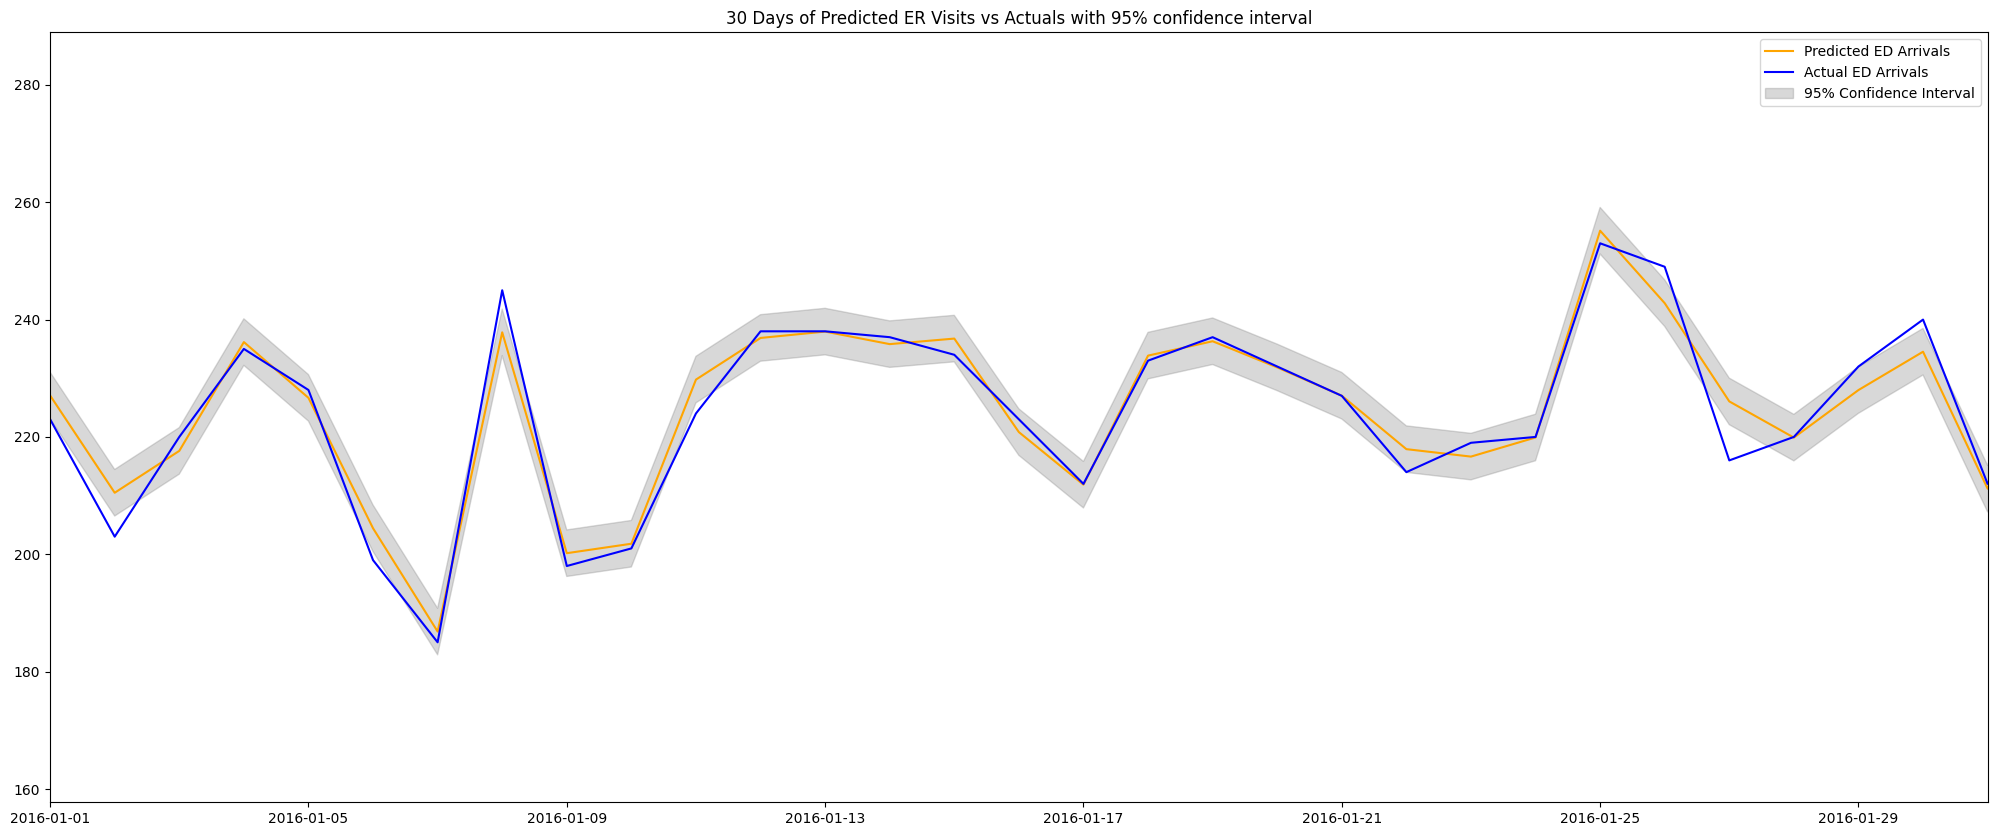

In [7]:
#apply model to the test data
dtest_reg = xgb.DMatrix(X_test)
preds_test = final_model.predict(X_test)

# Calculate rolling averages
window_size = 14  # 14-day rolling window
y_test_smoothed = y_test.rolling(window=window_size).mean()
preds_test_smoothed = pd.Series(preds_test, index=y_test.index).rolling(window=window_size).mean()

# Calculate residuals on training data
residuals = y_train['attendences'] - final_model.predict(X_train)

# Calculate the standard deviation of these residualsa
error_std = np.std(residuals)

# Generate upper and lower confidence bounds
confidence_interval = 1.96 * error_std  # 95% confidence interval
upper_bound = preds_test + confidence_interval
lower_bound = preds_test - confidence_interval
#smooth upper and lower bounds
upper_bound_smoothed = pd.Series(upper_bound, index=y_test.index).rolling(window=window_size).mean()
lower_bound_smoothed = pd.Series(lower_bound, index=y_test.index).rolling(window=window_size).mean()

plt.figure(figsize=(25,10))
plt.plot(y_test.index, preds_test, label='Predicted ED Arrivals', color='orange')
plt.plot(y_test.index, y_test, label='Actual ED Arrivals', color='blue')
plt.fill_between(y_test.index, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.legend()
#limit window to 30 days
plt.xlim([y_test.index[0], y_test.index[30]])
plt.title('30 Days of Predicted ER Visits vs Actuals with 95% confidence interval')
plt.show()